In [ ]:
# Instalação de alguns pacotes que serão usados, pois eles não vem instalados por padrão
%pip install mlflow
%pip install hyperopt
%pip install xgboost

In [5]:
# Importando bibliotecas para visualização e manipulação dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


<h2>Analise Exploratoria

In [95]:
dados = pd.read_csv('/dbfs/FileStore/water_potability.csv') # Importando os dados
dados.head() # Mostrado as 5 primeiras linhas do dataset

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# Verificando a quantidade de linhas e colunas( 3.276 linhas e 10 colunas )
dados.shape 

Out[3]: (3276, 10)

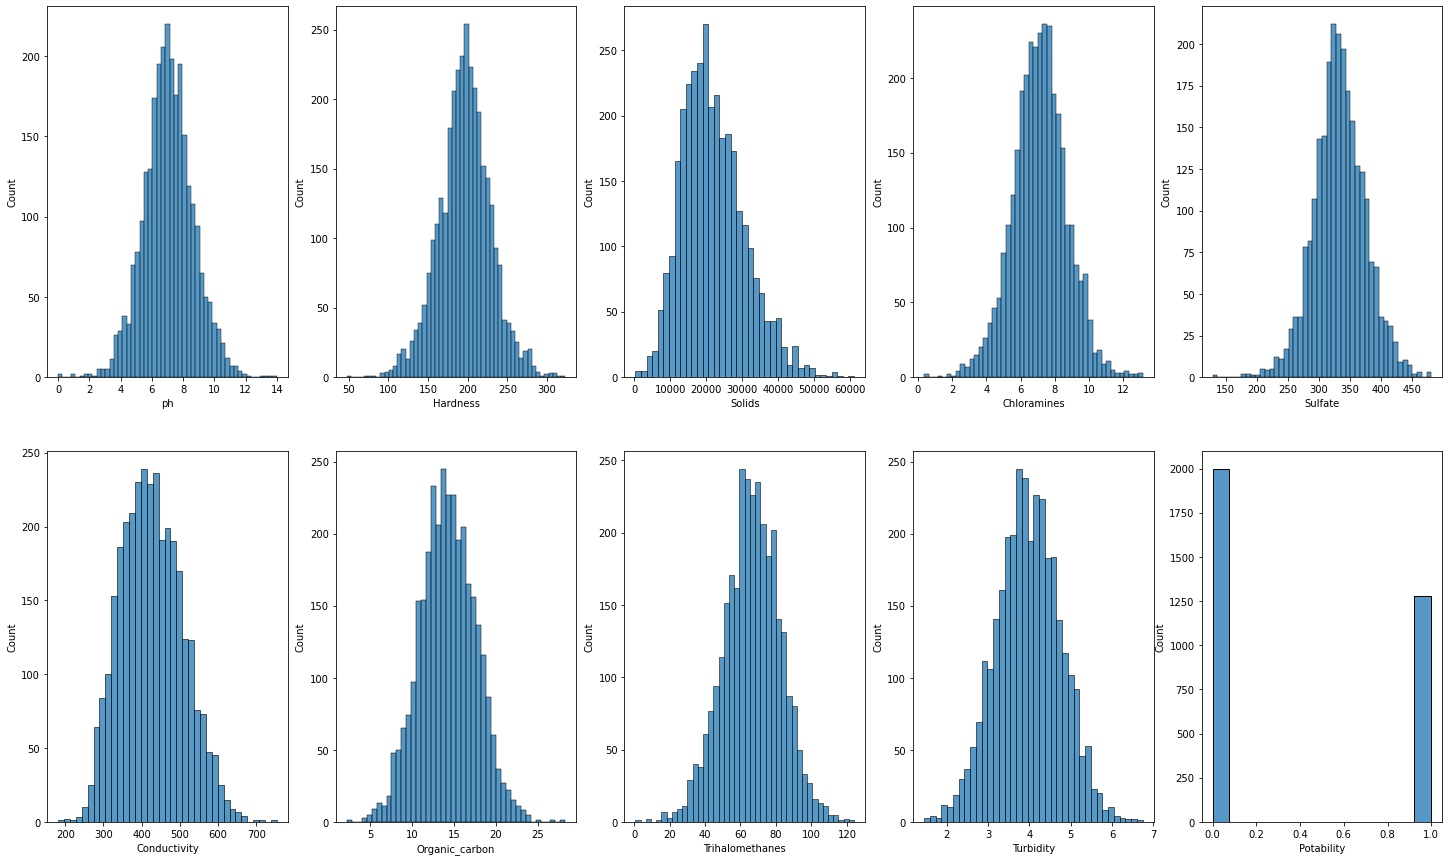

In [ ]:
# Cria um conjundo de graficos de histograma para vizualizar a distribuição dos dados

dims = (2, 5)
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in dados.columns:
    sns.histplot(dados[col], kde=False, ax=axes[axis_i, axis_j])
    axis_j += 1
    if axis_j == dims[1]:
        axis_i += 1
        axis_j = 0

Como pode ser observado nos graficos acima, a maioria das variaveis segue uma distribuição uniforme.
<br> Um outro detalhe é que a variavel alvo```Potability``` parece estar levemente desbalanceada.
<br><br><br>

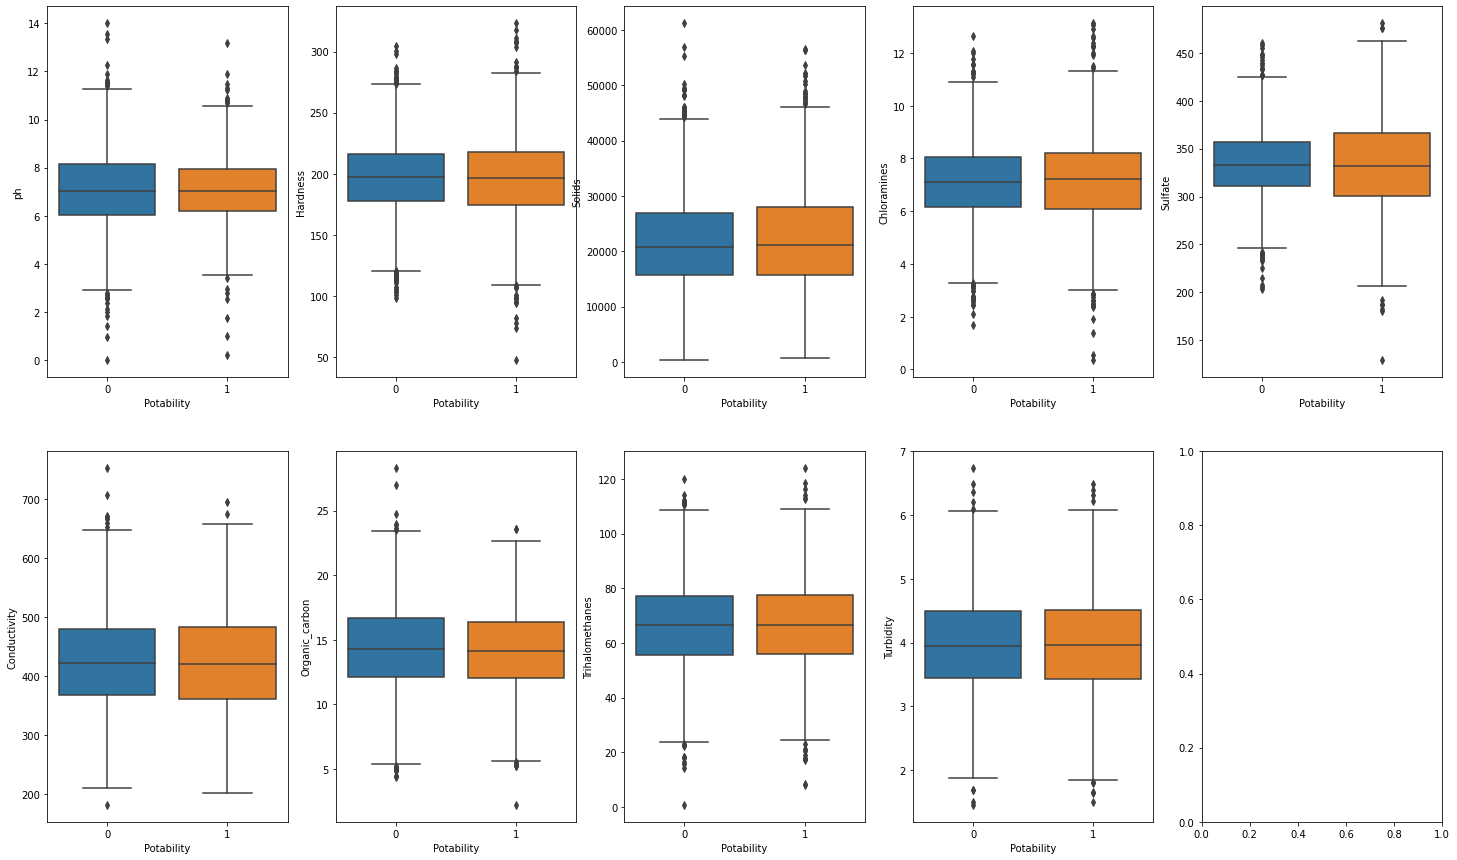

In [ ]:
# Cria um conjundo de graficos para vizualizar comparar os dados
dims = (2, 5)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in dados.columns:
    if col == 'Potability': # Para não comparar a propria coluna de aprovado ou não
        continue
    if dados[col].dtypes != 'O':
        sns.boxplot(data=dados, x="Potability", y=col, orient='v', ax=axes[axis_i, axis_j]) # Mostra o boxplot caso a variavel seja nominal
    else:
        pd.crosstab(dados['Potability'],dados[col], normalize='index').plot.bar(stacked=True, rot=0, ax=axes[axis_i, axis_j]) # Mostra o grafico de barras caso a variavel seja categorica
    axis_j += 1
    if axis_j == dims[1]:
        axis_i += 1
        axis_j = 0

De acordo com o grafico acima, que compara as variaveis de entrada com a variavel alvo ```Potability```, á duas observações a serem feitas. A primeira é que para uma agua ser potavel o intervalo de ph é um pouco menor que a de uma agua não potavel, e a segunda é que o intervalo de valores da variavel ```Sulfate``` é um pouco maior para uma agua ser potavel.
<br><br><br>

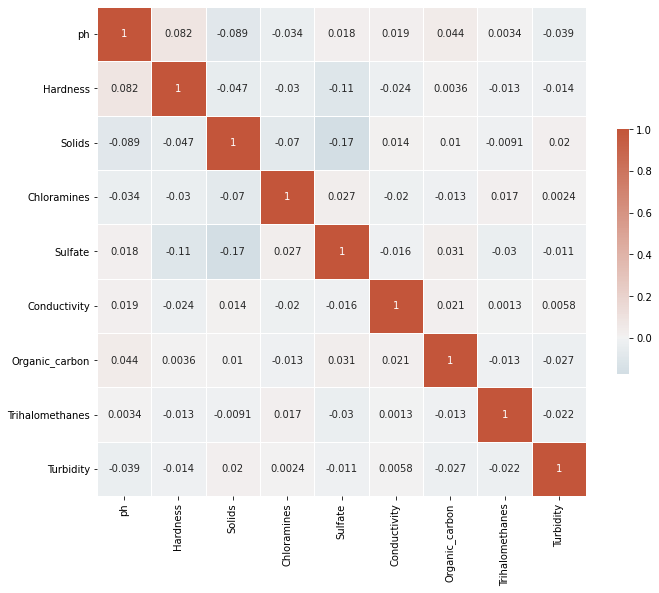

In [ ]:
# Cria um mapa de calor para vizualizar a correlação entre as variaveis
corr = dados.corr().iloc[0:-1, 0:-1]

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

De acordo com o grafico acima, a correlação entre as variaveis é muito baixa.
<br><br><br>
<br><br><br>

<h2> Pre-processamento

In [96]:
# Verifica a quantidade de valores faltantes que existem em cada coluna.
dados.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
# Verifica se existe valores duplicados
dados[dados.duplicated(keep=False)]

Out[8]:

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability


In [39]:
# A seguinte função preenche os valores nulos de uma coluna da seguinte forma:
def NaFill(dataset, coluna, tipo):  # Recebe 3 variaveis, o dataset, o nome da coluna, e o tipo de variavel que é os valores da coluna
    
    median = dataset[coluna].median()  # É calculado a mediana da coluna
    std = dataset[coluna].std()   # É calculado o desvio padrão da coluna
    if tipo == 'int':
        # Se o tipo da coluna for do tipo inteiro, a função randint recebe um intervalo de valores que sera usado para ser gerado aleatoriamente 
        # e a quantidade de valores que serão gerados
        # No caso abaixo, a função esta recebendo como intervalo (A mediana - O desvio padrao) ate (A mediana + O desvio padrao) e a quantidade de valores nulos na coluna
        ag = np.random.randint(median - std, median + std, dataset[coluna].isnull().sum()) 
    elif tipo == 'float':    
        # Executa a mesma funcionalidade que a função anterior a diferença é que ele retorna valores decimais.
        ag = np.random.uniform(median - std, median + std, dataset[coluna].isnull().sum())
    else:
        print('opção invalida')
    inx = dataset.index[dataset[coluna].isnull() == True]
    return pd.Series(data=ag, index=inx)      # É retornado um objeto series(parecido com uma lista) com os valores gerados como indice as linhas que tem os valores nulos
    
        

In [40]:
# Exemplo de valores retornados pela função
NaFill(dados,'ph','float')

0       7.281402
8       7.402974
13      6.406861
20      7.045881
22      5.664723
          ...   
3224    6.825777
3229    8.140354
3231    6.996604
3245    7.319861
3260    6.855397
Length: 491, dtype: float64

In [41]:
# É aplicada a função "NaFill" nas 3 colunas que tem valores nulos
dados['ph'].fillna(value=NaFill(dados,'ph','float'), axis=0, inplace=True)
dados['Sulfate'].fillna(value=NaFill(dados,'Sulfate','float'), axis=0, inplace=True)
dados['Trihalomethanes'].fillna(value=NaFill(dados,'Trihalomethanes','float'), axis=0, inplace=True)

In [42]:
# agora pode ser visto que não existe mais valores nulos no dataset
dados.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [ ]:
dados.head()

Out[13]:

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.921372,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,330.942335,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,352.855197,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


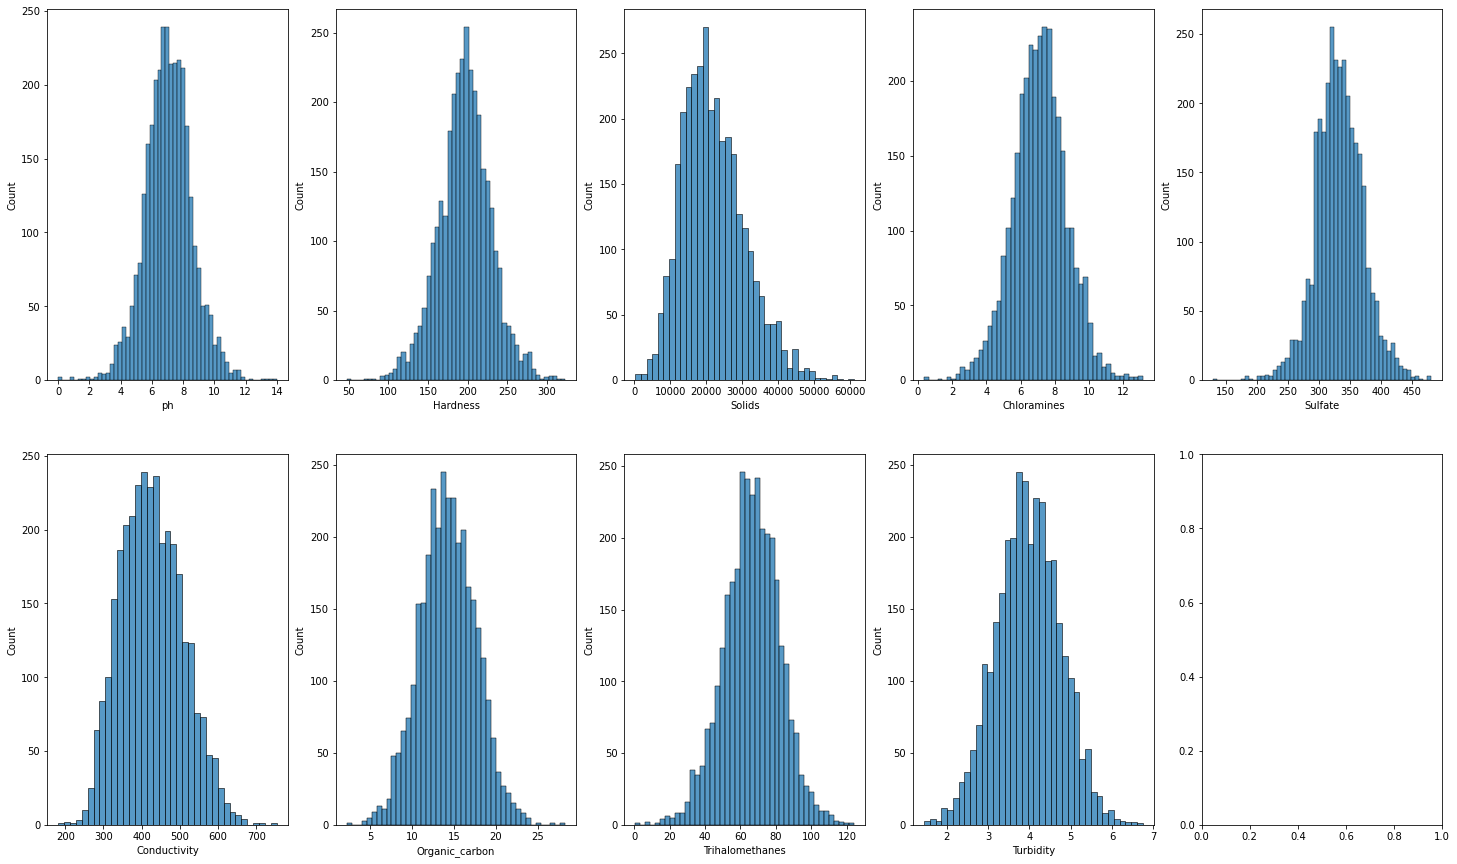

In [ ]:
dims = (2, 5)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in dados.columns:
    if col == 'Potability':
        continue
    sns.histplot(dados[col], kde=False, ax=axes[axis_i, axis_j])
    axis_j += 1
    if axis_j == dims[1]:
        axis_i += 1
        axis_j = 0

Comparando o grafico acima com o anterior parecido com esse, após esse metodo de preenchimento de valores nulos ser aplicado, não foi realizada uma mudança significativa na distribuição dos dados.
<br><br><br>

In [43]:
# Separando as variaveis preditoras da variavel alvo
x = dados.drop(['Potability'],axis=1)
y = dados['Potability']

In [44]:
x.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.752387,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,307.473762,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,361.351065,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075


In [45]:
# valores da variavel alvo
y

0       0
1       0
2       0
3       0
4       0
       ..
3271    1
3272    1
3273    1
3274    1
3275    1
Name: Potability, Length: 3276, dtype: int64

In [46]:
# importa função para separar os dados em treino e teste
from sklearn.model_selection import train_test_split

In [47]:
# Os dados são separados 75% para treino e 25% para teste (valores padrão da função)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.25, random_state=123)

In [ ]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK  # importa biblioteca para encontrar os melhores parametros para a melhor performance do modelo
from hyperopt.pyll import scope
import mlflow.xgboost  # Importa biblioteca usada para criar um log do modelo xgboost
import mlflow   # importa biblioteca mlflow para gerencias os modelos de ml
import numpy as np   # importa biblioteca para calculos com matrizes e vetores
import xgboost as xgb   # importa o algoritmo de aprendizado de maquina que sera usado para criar o modelo
from sklearn.metrics import roc_auc_score  # importa as metricas auc e roc para avaliar o desempenho de acerto do modelo
from mlflow.models.signature import infer_signature # importa biblioteca para registrar uma assinatura no modelo

<h2> Construindo e treinando o modelo

In [ ]:
# Um dicionario que define quais os hiperparametros que ira ser feito o tunning e o intervalo de valores que sera usado
interParam = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, 
}

In [ ]:
def fluxoXGB(parametros):
  
  # Função que registra automaticamente os hiperparametros e o modelo treinado no MLflow.
  mlflow.xgboost.autolog()
 
  # Inicia o rastreamento do desempenho do modelo
  with mlflow.start_run(nested = True):
    
    # Dados de treino e teste convertidos para um formato que o Xgboost utiliza para treinar o modelo
    treino = xgb.DMatrix(data = x_treino, label = y_treino)
    teste = xgb.DMatrix(data = x_teste, label = y_teste)
    
    # Passamos pelo conjunto de teste para que o XGBoost possa rastrear uma métrica de avaliação. 
    # O XGBoost encerra o treinamento quando a métrica de avaliação não está mais melhorando.
    # O modelo xgb é treinado e o resultado é armazenado na variavel "xgbModelo"
    xgbModelo = xgb.train(params = parametros, dtrain = treino,num_boost_round = 1000, evals = [(teste, "teste")], early_stopping_rounds = 50)  
    
    # Previsões com o dataset teste
    valoresPrevistos = xgbModelo.predict(teste)
    
    # calcula o desempenho do modelo
    pontuacao = roc_auc_score(y_teste, valoresPrevistos)
    
    # Coloca no log do mlflow a metrica como uma coluna para ser vizualizado em experiments
    mlflow.log_metric('auc', pontuacao)

    # Cria uma assinatura para o modelo
    assinatura = infer_signature(x_treino, xgbModelo.predict(treino))
    
    # Carrega o modelo no mlflow
    mlflow.xgboost.log_model(xgbModelo, "modelo", signature = assinatura)
    
    #retorn "STATUS_OK" quer dizer que o treino foi bem sucedido, retorna a acuracia do modelo e os hiperparametros que foram usados
    return {'status': STATUS_OK, 'loss': pontuacao, 'booster': xgbModelo.attributes()}

In [ ]:
# Executando a função fmin dentro do escopo do mlflow, cada modelo testado com os hipermarametros variados sera agrupado no 'xgboostExp'
with mlflow.start_run(run_name = 'xgboostExp'):
    # a função fmin vai treinar e testar o modelo 15 vezes, ela retorna os melhores parametros.
    fmin(fn = fluxoXGB, 
         space = interParam, 
         algo = tpe.suggest, 
         max_evals = 15)

<h2> Registrando o modelo

In [ ]:
# Seleciona o modelo que teve uma melhor peformance
melhorExp = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'Experimento com melhor AUC: {melhorExp["metrics.auc"]}')

Experimento com melhor AUC: 0.6690294507157721

In [ ]:
#Nome do modelo que sera registrado
Nmodelo = "modelo_qualidade_agua"

In [ ]:
# Registra um modelo versionado para ser utilizado
modeloML = mlflow.register_model(f"runs:/{melhorExp.run_id}/model", Nmodelo)

# Registrar o modelo demora um tempo, o Databricks recomenda esperar 300 segundos para finalizar o registro do modelo

Successfully registered model 'modelo_qualidade_agua'.
2022/11/12 22:44:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: modelo_qualidade_agua, version 1
Created version '1' of model 'modelo_qualidade_agua'.

<h2> Consumindo o modelo via API

In [3]:
import os
#defini a variavel de ambiente o token que o usuario gera no site do Databricks
os.environ["DATABRICKS_TOKEN"] = 'Seu Token'

In [4]:
# Codigo recomendado pelo Databricks para consumir o modelo por api em python
import os
import requests
import numpy as np
import pandas as pd
import json

def create_tf_serving_json(data):
  return {'inputs': {name: data[name].tolist() for name in data.keys()} if isinstance(data, dict) else data.tolist()}

def score_model(dataset):
  url = 'https://adb-5577970459403938.18.azuredatabricks.net/model/modelo_qualidade_agua/1/invocations'
  headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}', 'Content-Type': 'application/json'}
  ds_dict = dataset.to_dict(orient='split') if isinstance(dataset, pd.DataFrame) else create_tf_serving_json(dataset)
  data_json = json.dumps(ds_dict, allow_nan=True)
  response = requests.request(method='POST', headers=headers, url=url, data=data_json)
  if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
  return response.json()

In [92]:

dadobruto = score_model(x_teste[270:280]) # entrega em forma de probabilidade
dadotratado = [1 if x >= 0.7 else 0 for x in dadobruto] # Utiliza List Comprehension para fazer a seguinte verificação, se a probabilidade for 70% é considerado que a agua esta boa para consumo.

In [93]:
# Vizualizando as predições em uma tabela
previsoes = x_teste[270:280].assign(
                previsoes_brutas= dadobruto,
                previsoes_tratadas= dadotratado)
previsoes

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,previsoes_brutas,previsoes_tratadas
2069,7.446089,179.146836,17763.310993,9.876515,328.459022,364.134173,12.982491,49.051241,2.948657,0.360246,0
2190,7.312109,199.812999,14540.735082,8.827414,276.118282,486.983734,17.271656,70.135608,5.123872,0.809109,1
1915,6.728975,187.202712,26376.062287,8.457662,337.861922,488.976394,17.689785,77.131889,4.593787,0.395442,0
2375,8.764496,210.851346,15978.036559,8.043354,328.759844,324.047375,12.128377,59.789163,5.790838,0.729742,1
1689,7.614057,213.691169,17598.200350,8.131319,341.580398,384.087281,5.051695,70.833219,3.437946,0.661784,0
184,5.877974,141.615287,13652.293199,5.701659,279.782400,538.495404,12.034042,67.907258,4.032260,0.308979,0
2196,8.616824,228.762945,19126.298537,7.017578,327.894821,383.527023,14.759257,41.275927,4.584566,0.241787,0
1353,11.534880,183.262261,4111.785432,7.416773,398.955345,475.255395,10.839796,69.420035,3.000096,0.139841,0
2857,6.483617,154.925972,30037.221625,5.796571,252.067267,311.750019,13.904652,77.532042,4.113585,0.795249,1
511,7.291957,202.329044,21891.677159,7.628747,339.829014,379.270122,7.654956,64.021523,4.237644,0.369252,0
